In [4]:
!pip install datasets rouge_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.8 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=2130d9066fde606fe3d312049bf0627aabfbb66400312089570b17894489407d
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from transformers import GPT2LMHeadModel, GPT2Tokenizer

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np
import matplotlib.pyplot as plt

# Import ROUGE scorer
from rouge_score import rouge_scorer

# ---------------------------
# Helper Functions
# ---------------------------
def group_sentences_into_segments(document, group_size=5):
    sentences = sent_tokenize(document)
    segments = [" ".join(sentences[i:i+group_size]) for i in range(0, len(sentences), group_size)]
    return segments

def compute_cosine_similarity(vec1, vec2):
    return F.cosine_similarity(vec1, vec2, dim=0).item()

def compute_perplexity(text, gpt2_model, gpt2_tokenizer, device):
    inputs = gpt2_tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    input_ids = inputs.input_ids.to(device)
    with torch.no_grad():
        outputs = gpt2_model(input_ids, labels=input_ids)
        loss = outputs.loss
    perplexity = torch.exp(loss)
    fluency_reward = np.exp(-perplexity.item() / 100.0)
    return fluency_reward

def compute_self_bleu(sentences):
    smoothie = SmoothingFunction().method1
    bleu_scores = []
    for i, sent in enumerate(sentences):
        refs = [s.split() for j, s in enumerate(sentences) if j != i]
        candidate = sent.split()
        if refs:
            score = sentence_bleu(refs, candidate, smoothing_function=smoothie)
            bleu_scores.append(score)
    return np.mean(bleu_scores) if bleu_scores else 0.0

# Initialize the ROUGE scorer once
rouge_scorer_instance = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

def compute_rouge_reward(generated_summary, target_summary):
    scores = rouge_scorer_instance.score(target_summary, generated_summary)
    rouge1 = scores['rouge1'].fmeasure
    rougeL = scores['rougeL'].fmeasure
    return (rouge1 + rougeL) / 2.0

# ---------------------------
# Actor (Policy) Networks with sanitization
# ---------------------------
class SegmentPolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SegmentPolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        h = F.relu(self.fc1(x))
        logit = self.fc2(h)
        prob = torch.sigmoid(logit)
        # Replace any NaNs with 0.5 and clamp within (1e-6, 1-1e-6)
        prob = torch.nan_to_num(prob, nan=0.5)
        prob = torch.clamp(prob, 1e-6, 1 - 1e-6)
        return prob

class SentencePolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SentencePolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        h = F.relu(self.fc1(x))
        logit = self.fc2(h)
        prob = torch.sigmoid(logit)
        prob = torch.nan_to_num(prob, nan=0.5)
        prob = torch.clamp(prob, 1e-6, 1 - 1e-6)
        return prob

# ---------------------------
# Critic Networks (unchanged)
# ---------------------------
class SegmentCriticNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SegmentCriticNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        h = F.relu(self.fc1(x))
        value = self.fc2(h)
        return value

class SentenceCriticNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SentenceCriticNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        h = F.relu(self.fc1(x))
        value = self.fc2(h)
        return value

# ---------------------------
# Main Training Routine with Integrated Measures
# ---------------------------
def main():
    # Assign devices (multi-GPU if available)
    device0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    device1 = torch.device("cuda:1" if torch.cuda.device_count() > 1 else device0)

    # Load dataset.
    dataset = load_dataset("FiscalNote/billsum", split="train[:200]")

    # Initialize SentenceTransformer.
    sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

    # Initialize GPT-2 for fluency evaluation.
    gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device0)
    gpt2_model.eval()

    # Hyperparameters.
    sbert_dim = 384
    hidden_dim = 128
    max_segments = 100
    max_sentences = 10

    # Positional embeddings.
    segment_pos_embed = nn.Embedding(max_segments, 1).to(device0)
    sentence_pos_embed = nn.Embedding(max_sentences, 1).to(device1)

    # Input dimensions.
    seg_input_dim = sbert_dim + 1 + sbert_dim
    sent_input_dim = sbert_dim + 1 + sbert_dim

    # High-level networks (on device0).
    segment_actor = SegmentPolicyNetwork(seg_input_dim, hidden_dim).to(device0)
    segment_critic = SegmentCriticNetwork(seg_input_dim, hidden_dim).to(device0)

    # Low-level networks (on device1).
    sentence_actor = SentencePolicyNetwork(sent_input_dim, hidden_dim).to(device1)
    sentence_critic = SentenceCriticNetwork(sent_input_dim, hidden_dim).to(device1)

    # Optimizer: combine parameters from all networks.
    optimizer = optim.Adam(
        list(segment_actor.parameters()) + list(segment_critic.parameters()) +
        list(sentence_actor.parameters()) + list(sentence_critic.parameters()) +
        list(segment_pos_embed.parameters()) + list(sentence_pos_embed.parameters()),
        lr=1e-4
    )

    # Reward weights.
    lambda_content = 1.0
    lambda_fluency = 1.0
    lambda_diversity = -1.0
    lambda_rouge = 1.0

    num_epochs = 50
    epoch_losses = []
    epoch_total_rewards = []
    best_loss = float('inf')
    patience = 5
    patience_counter = 0

    # Clear the cumulative file.
    cumulative_file = "cumulative_epoch_summaries.txt"
    with open(cumulative_file, "w") as f:
        f.write("Cumulative Epoch Summaries:\n" + "=" * 80 + "\n")

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        epoch_similarity = 0.0
        epoch_fluency = 0.0
        epoch_diversity = 0.0
        epoch_rouge = 0.0
        epoch_final_reward = 0.0
        num_batches = 0

        for data in dataset:
            document = data["text"]
            target_summary_text = data["summary"]
            if not document or not target_summary_text:
                continue

            segments = group_sentences_into_segments(document, group_size=5)
            if len(segments) == 0:
                continue

            all_sentences = sent_tokenize(document)
            if len(all_sentences) == 0:
                continue
            # Clean embeddings to avoid propagation of NaNs.
            doc_embeddings = torch.nan_to_num(sbert_model.encode(all_sentences, convert_to_tensor=True).float()).to(device0)
            doc_context = torch.nan_to_num(torch.mean(doc_embeddings, dim=0)).to(device0)

            # ---------------------------
            # High-Level: Segment Selection (device0)
            seg_inputs = []
            selected_seg_indices = []
            seg_embeddings = []
            for idx, seg in enumerate(segments):
                seg_emb = torch.nan_to_num(sbert_model.encode(seg, convert_to_tensor=True).float())
                seg_embeddings.append(seg_emb)
                pos_scalar = segment_pos_embed(torch.tensor(idx, dtype=torch.long, device=device0))
                # Clean the concatenated state.
                seg_state = torch.nan_to_num(torch.cat([seg_emb.to(device0), pos_scalar, doc_context], dim=0))
                seg_inputs.append(seg_state)
            seg_inputs_tensor = torch.stack(seg_inputs).to(device0)
            seg_probs = segment_actor(seg_inputs_tensor).squeeze()
            seg_dist = torch.distributions.Bernoulli(seg_probs)
            seg_actions = seg_dist.sample()
            seg_log_probs = seg_dist.log_prob(seg_actions)
            seg_values = segment_critic(seg_inputs_tensor).squeeze()

            for i, a in enumerate(seg_actions):
                if a.item() == 1:
                    selected_seg_indices.append(i)
            if not selected_seg_indices:
                selected_seg_indices = [int(torch.argmax(seg_probs).item())]
                seg_actions = torch.zeros_like(seg_actions)
                seg_actions[selected_seg_indices[0]] = 1.0

            # ---------------------------
            # Low-Level: Sentence Selection (device1)
            sent_actor_log_probs = []
            selected_sentences = []
            sent_values_list = []
            for seg_idx in selected_seg_indices:
                seg_text = segments[seg_idx]
                sentences = sent_tokenize(seg_text)
                if len(sentences) == 0:
                    continue
                sentences = sentences[:max_sentences]
                seg_context = torch.nan_to_num(seg_embeddings[seg_idx]).to(device1)
                for jdx, sent in enumerate(sentences):
                    sent_emb = torch.nan_to_num(sbert_model.encode(sent, convert_to_tensor=True).float())
                    pos_scalar_sent = sentence_pos_embed(torch.tensor(jdx, dtype=torch.long, device=device1))
                    sent_state = torch.nan_to_num(torch.cat([sent_emb.to(device1), pos_scalar_sent, seg_context], dim=0))
                    sent_prob = sentence_actor(sent_state)
                    sent_dist = torch.distributions.Bernoulli(sent_prob)
                    sent_action = sent_dist.sample()
                    sent_log_prob = sent_dist.log_prob(sent_action)
                    sent_actor_log_probs.append(sent_log_prob)
                    sent_value = sentence_critic(sent_state)
                    sent_values_list.append(sent_value.squeeze())
                    if sent_action.item() == 1:
                        selected_sentences.append(sent)

            if not selected_sentences:
                first_seg_sentences = sent_tokenize(segments[selected_seg_indices[0]])
                if first_seg_sentences:
                    selected_sentences.append(first_seg_sentences[0])

            # ---------------------------
            # Generate summary with importance ranking.
            sentence_scores = []
            for sent in selected_sentences:
                sent_emb = torch.nan_to_num(sbert_model.encode(sent, convert_to_tensor=True).float()).to(device0)
                score = compute_cosine_similarity(sent_emb, doc_context)
                sentence_scores.append(score)
            sorted_sentences = [sent for _, sent in sorted(zip(sentence_scores, selected_sentences),
                                                             key=lambda pair: pair[0],
                                                             reverse=True)]
            max_summary_length = len(document.split()) // 3
            final_summary_sentences = []
            current_word_count = 0
            for sent in sorted_sentences:
                sent_word_count = len(sent.split())
                if current_word_count + sent_word_count <= max_summary_length:
                    final_summary_sentences.append(sent)
                    current_word_count += sent_word_count
                else:
                    break
            generated_summary = " ".join(final_summary_sentences)

            # ---------------------------
            # Reward Computation.
            gen_sentences = sent_tokenize(generated_summary)
            target_sentences = sent_tokenize(target_summary_text)
            if len(gen_sentences) == 0 or len(target_sentences) == 0:
                continue
            gen_emb = torch.nan_to_num(torch.mean(sbert_model.encode(gen_sentences, convert_to_tensor=True).float(), dim=0))
            target_emb = torch.nan_to_num(torch.mean(sbert_model.encode(target_sentences, convert_to_tensor=True).float(), dim=0))
            similarity_reward = compute_cosine_similarity(gen_emb, target_emb)
            fluency_reward = compute_perplexity(generated_summary, gpt2_model, gpt2_tokenizer, device0)
            self_bleu = compute_self_bleu(selected_sentences)
            diversity_reward = 1.0 - self_bleu
            rouge_reward = compute_rouge_reward(generated_summary, target_summary_text)

            final_reward = (lambda_content * similarity_reward +
                            lambda_fluency * fluency_reward +
                            lambda_diversity * diversity_reward +
                            lambda_rouge * rouge_reward)

            epoch_similarity += similarity_reward
            epoch_fluency += fluency_reward
            epoch_diversity += diversity_reward
            epoch_rouge += rouge_reward
            epoch_final_reward += final_reward

            # ---------------------------
            # Actor-Critic Loss Computation.
            seg_actor_loss = 0.0
            seg_critic_loss = 0.0
            for i in range(len(seg_actions)):
                if seg_actions[i].item() == 1:
                    advantage = final_reward - seg_values[i]
                    seg_actor_loss += -seg_log_probs[i] * advantage
                    seg_critic_loss += F.mse_loss(seg_values[i], torch.tensor(final_reward, dtype=torch.float32, device=device0))
            sent_actor_loss = 0.0
            sent_critic_loss = 0.0
            for i in range(len(sent_actor_log_probs)):
                advantage = final_reward - sent_values_list[i]
                sent_actor_loss += -sent_actor_log_probs[i] * advantage
                sent_critic_loss += F.mse_loss(sent_values_list[i], torch.tensor(final_reward, dtype=torch.float32, device=device1))
            total_loss = seg_actor_loss + seg_critic_loss + sent_actor_loss.to(device0) + sent_critic_loss.to(device0)

            # If the loss is negative, propagate its absolute value.
            if total_loss.item() < 0:
                total_loss = torch.abs(total_loss)

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            epoch_loss += total_loss.item()
            num_batches += 1

        # Compute average values for the epoch.
        if num_batches > 0:
            avg_epoch_loss = epoch_loss / num_batches
            avg_similarity = epoch_similarity / num_batches
            avg_fluency = epoch_fluency / num_batches
            avg_diversity = -(epoch_diversity / num_batches)
            avg_rouge = epoch_rouge / num_batches
            avg_final_reward = epoch_final_reward / num_batches
        else:
            avg_epoch_loss = avg_similarity = avg_fluency = avg_diversity = avg_rouge = avg_final_reward = 0.0

        epoch_losses.append(avg_epoch_loss)
        epoch_total_rewards.append(avg_final_reward)

        summary_str = (
            f"Epoch {epoch+1} Summary:\n"
            f"  Average Similarity Reward: {avg_similarity:.4f}\n"
            f"  Average Fluency Reward:     {avg_fluency:.4f}\n"
            f"  Average Diversity Reward:   {avg_diversity:.4f}\n"
            f"  Average ROUGE Reward:       {avg_rouge:.4f}\n"
            f"  Average Total Reward:       {avg_final_reward:.4f}\n"
            f"  Average Loss:               {avg_epoch_loss:.4f}\n"
            + "=" * 80 + "\n"
        )

        print(summary_str)
        with open(cumulative_file, "a") as f:
            f.write(summary_str)

        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            patience_counter = 0
            checkpoint = {
                'epoch': epoch + 1,
                'segment_actor': segment_actor.state_dict(),
                'sentence_actor': sentence_actor.state_dict(),
                'segment_critic': segment_critic.state_dict(),
                'sentence_critic': sentence_critic.state_dict(),
                'segment_pos_embed': segment_pos_embed.state_dict(),
                'sentence_pos_embed': sentence_pos_embed.state_dict(),
                'optimizer': optimizer.state_dict(),
                'loss': avg_epoch_loss
            }
            torch.save(checkpoint, "best_model.pth")
            print(f"Saved best model at epoch {epoch+1} with loss {avg_epoch_loss:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}.")
                break

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o', label="Loss")
    plt.plot(range(1, len(epoch_total_rewards)+1), epoch_total_rewards, marker='x', label="Avg Total Reward")
    plt.title("Loss and Total Reward Curve Across Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Epoch 1 Summary:
  Average Similarity Reward: 0.6300
  Average Fluency Reward:     0.8773
  Average Diversity Reward:   -0.8881
  Average ROUGE Reward:       0.2912
  Average Total Reward:       0.9104
  Average Loss:               46.7429

Saved best model at epoch 1 with loss 46.7429
Epoch 2 Summary:
  Average Similarity Reward: 0.6498
  Average Fluency Reward:     0.8944
  Average Diversity Reward:   -0.8789
  Average ROUGE Reward:       0.3033
  Average Total Reward:       0.9686
  Average Loss:               22.9094

Saved best model at epoch 2 with loss 22.9094
Epoch 3 Summary:
  Average Similarity Reward: 0.6605
  Average Fluency Reward:     0.8992
  Average Diversity Reward:   -0.8598
  Average ROUGE Reward:       0.3016
  Average Total Reward:       1.0015
  Average Loss:               6.3947

Saved best model at epoch 3 with loss 6.3947
Epoch 4 Summary:
  Average Similarity Reward: 0.6803
  Average Fluency Reward:     0.9049
  Average Diversity Reward:   -0.8631
  Average ROU

KeyboardInterrupt: 

Training Results Across All Epochs:
Highest Total Reward: 1.0789 (Epoch 18)
Lowest Loss: 1.3281 (Epoch 20)
Highest ROUGE Score: 0.3075 (Epoch 17)
Highest Similarity Reward: 0.7006 (Epoch 18)
Highest Fluency Reward: 0.9144 (Epoch 9)
Highest Diversity Reward: -0.8356 (Epoch 18)


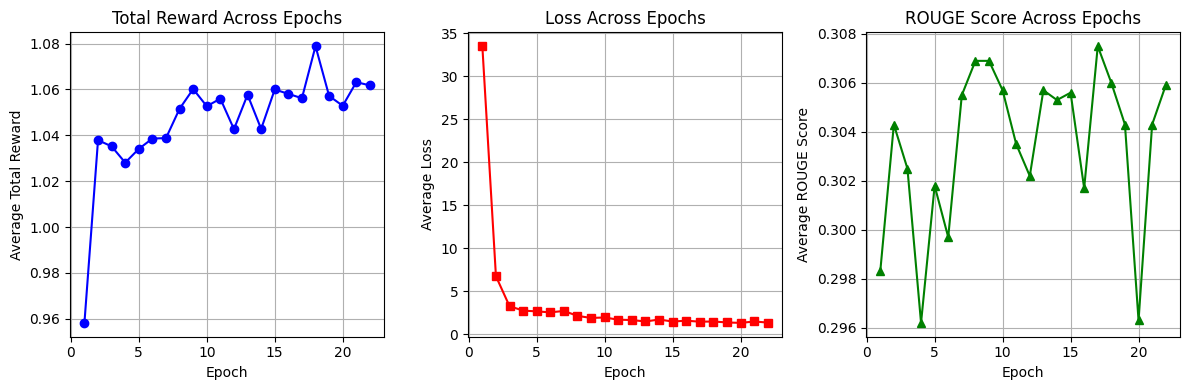

In [3]:
import matplotlib.pyplot as plt
import re

# Load the cumulative summary file
file_path = "cumulative_epoch_summaries.txt"
with open(file_path, "r") as f:
    lines = f.readlines()

# Extract epoch data
epochs = []
total_rewards = []
losses = []
rouge_scores = []
similarity_rewards = []
fluency_rewards = []
diversity_rewards = []

for line in lines:
    epoch_match = re.search(r"Epoch (\d+) Summary", line)
    if epoch_match:
        epochs.append(int(epoch_match.group(1)))

    reward_match = re.search(r"Average Total Reward:\s+([\d\.]+)", line)
    if reward_match:
        total_rewards.append(float(reward_match.group(1)))

    loss_match = re.search(r"Average Loss:\s+([\d\.]+)", line)
    if loss_match:
        losses.append(float(loss_match.group(1)))

    rouge_match = re.search(r"Average ROUGE Reward:\s+([\d\.]+)", line)
    if rouge_match:
        rouge_scores.append(float(rouge_match.group(1)))

    similarity_match = re.search(r"Average Similarity Reward:\s+([\d\.]+)", line)
    if similarity_match:
        similarity_rewards.append(float(similarity_match.group(1)))

    fluency_match = re.search(r"Average Fluency Reward:\s+([\d\.]+)", line)
    if fluency_match:
        fluency_rewards.append(float(fluency_match.group(1)))

    diversity_match = re.search(r"Average Diversity Reward:\s+([-\d\.]+)", line)
    if diversity_match:
        diversity_rewards.append(float(diversity_match.group(1)))

# Find highest values
max_total_reward = max(total_rewards)
min_loss = min(losses)
max_rouge = max(rouge_scores)
max_similarity = max(similarity_rewards)
max_fluency = max(fluency_rewards)
max_diversity = max(diversity_rewards)

# Find corresponding epochs
best_epoch_total_reward = epochs[total_rewards.index(max_total_reward)]
best_epoch_loss = epochs[losses.index(min_loss)]
best_epoch_rouge = epochs[rouge_scores.index(max_rouge)]
best_epoch_similarity = epochs[similarity_rewards.index(max_similarity)]
best_epoch_fluency = epochs[fluency_rewards.index(max_fluency)]
best_epoch_diversity = epochs[diversity_rewards.index(max_diversity)]

# Print highest results
print("Training Results Across All Epochs:")
print(f"Highest Total Reward: {max_total_reward:.4f} (Epoch {best_epoch_total_reward})")
print(f"Lowest Loss: {min_loss:.4f} (Epoch {best_epoch_loss})")
print(f"Highest ROUGE Score: {max_rouge:.4f} (Epoch {best_epoch_rouge})")
print(f"Highest Similarity Reward: {max_similarity:.4f} (Epoch {best_epoch_similarity})")
print(f"Highest Fluency Reward: {max_fluency:.4f} (Epoch {best_epoch_fluency})")
print(f"Highest Diversity Reward: {max_diversity:.4f} (Epoch {best_epoch_diversity})")

# Plot graphs
plt.figure(figsize=(12, 4))

# Plot Total Reward
plt.subplot(1, 3, 1)
plt.plot(epochs, total_rewards, marker='o', linestyle='-', color='b')
plt.xlabel("Epoch")
plt.ylabel("Average Total Reward")
plt.title("Total Reward Across Epochs")
plt.grid()

# Plot Loss
plt.subplot(1, 3, 2)
plt.plot(epochs, losses, marker='s', linestyle='-', color='r')
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Loss Across Epochs")
plt.grid()

# Plot ROUGE Score
plt.subplot(1, 3, 3)
plt.plot(epochs, rouge_scores, marker='^', linestyle='-', color='g')
plt.xlabel("Epoch")
plt.ylabel("Average ROUGE Score")
plt.title("ROUGE Score Across Epochs")
plt.grid()

# Show the plots
plt.tight_layout()
plt.show()

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import sent_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Download required nltk data
nltk.download('punkt')
nltk.download('punkt_tab')

# ---------------------------
# Helper Functions
# ---------------------------
def group_sentences_into_segments(document, group_size=5):
    sentences = sent_tokenize(document)
    segments = [" ".join(sentences[i:i+group_size]) for i in range(0, len(sentences), group_size)]
    return segments

def compute_cosine_similarity(vec1, vec2):
    return F.cosine_similarity(vec1, vec2, dim=0).item()

def compute_perplexity(text, gpt2_model, gpt2_tokenizer, device):
    inputs = gpt2_tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    input_ids = inputs.input_ids.to(device)
    with torch.no_grad():
        outputs = gpt2_model(input_ids, labels=input_ids)
        loss = outputs.loss
    perplexity = torch.exp(loss)
    fluency_reward = np.exp(-perplexity.item() / 100.0)
    return fluency_reward

def compute_self_bleu(sentences):
    smoothie = SmoothingFunction().method1
    bleu_scores = []
    for i, sent in enumerate(sentences):
        refs = [s.split() for j, s in enumerate(sentences) if j != i]
        candidate = sent.split()
        if refs:
            score = sentence_bleu(refs, candidate, smoothing_function=smoothie)
            bleu_scores.append(score)
    return np.mean(bleu_scores) if bleu_scores else 0.0

# Initialize the ROUGE scorer once
rouge_scorer_instance = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

# ---------------------------
# Network Classes (same as training)
# ---------------------------
class SegmentPolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SegmentPolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        h = F.relu(self.fc1(x))
        logit = self.fc2(h)
        prob = torch.sigmoid(logit)
        prob = torch.nan_to_num(prob, nan=0.5)
        prob = torch.clamp(prob, 1e-6, 1 - 1e-6)
        return prob

class SentencePolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SentencePolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        h = F.relu(self.fc1(x))
        logit = self.fc2(h)
        prob = torch.sigmoid(logit)
        prob = torch.nan_to_num(prob, nan=0.5)
        prob = torch.clamp(prob, 1e-6, 1 - 1e-6)
        return prob

class SegmentCriticNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SegmentCriticNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        h = F.relu(self.fc1(x))
        value = self.fc2(h)
        return value

class SentenceCriticNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SentenceCriticNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        h = F.relu(self.fc1(x))
        value = self.fc2(h)
        return value

# ---------------------------
# Testing Routine
# ---------------------------
def test_model():
    # Devices: use multi-GPU if available
    device0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    device1 = torch.device("cuda:1" if torch.cuda.device_count() > 1 else device0)

    # Hyperparameters
    sbert_dim = 384
    hidden_dim = 128
    max_segments = 100
    max_sentences = 10

    # Load test dataset (next 50 instances)
    test_dataset = load_dataset("FiscalNote/billsum", split="train[1000:1050]")

    # Initialize SBERT and GPT-2 for evaluation
    sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
    gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device0)
    gpt2_model.eval()

    # Positional embeddings
    segment_pos_embed = nn.Embedding(max_segments, 1).to(device0)
    sentence_pos_embed = nn.Embedding(max_sentences, 1).to(device1)

    # Input dimensions
    seg_input_dim = sbert_dim + 1 + sbert_dim
    sent_input_dim = sbert_dim + 1 + sbert_dim

    # Initialize networks
    segment_actor = SegmentPolicyNetwork(seg_input_dim, hidden_dim).to(device0)
    segment_critic = SegmentCriticNetwork(seg_input_dim, hidden_dim).to(device0)
    sentence_actor = SentencePolicyNetwork(sent_input_dim, hidden_dim).to(device1)
    sentence_critic = SentenceCriticNetwork(sent_input_dim, hidden_dim).to(device1)

    # Load the best checkpoint from training
    checkpoint = torch.load("best_model.pth", map_location=device0)
    segment_actor.load_state_dict(checkpoint['segment_actor'])
    segment_critic.load_state_dict(checkpoint['segment_critic'])
    sentence_actor.load_state_dict(checkpoint['sentence_actor'])
    sentence_critic.load_state_dict(checkpoint['sentence_critic'])
    segment_pos_embed.load_state_dict(checkpoint['segment_pos_embed'])
    sentence_pos_embed.load_state_dict(checkpoint['sentence_pos_embed'])

    # Set models to evaluation mode
    segment_actor.eval()
    segment_critic.eval()
    sentence_actor.eval()
    sentence_critic.eval()

    # Reward weights (same as training)
    lambda_content = 1.0
    lambda_fluency = 1.0
    lambda_diversity = -1.0
    lambda_rouge = 1.0

    # Initialize accumulators for metrics
    total_similarity = 0.0
    total_fluency = 0.0
    total_diversity = 0.0
    total_rouge1 = 0.0
    total_rougeL = 0.0
    total_reward = 0.0
    instance_count = 0

    with torch.no_grad():
        for data in test_dataset:
            document = data["text"]
            target_summary_text = data["summary"]
            if not document or not target_summary_text:
                continue

            segments = group_sentences_into_segments(document, group_size=5)
            if len(segments) == 0:
                continue

            all_sentences = sent_tokenize(document)
            if len(all_sentences) == 0:
                continue

            # Compute document context embedding
            doc_embeddings = torch.nan_to_num(sbert_model.encode(all_sentences, convert_to_tensor=True).float()).to(device0)
            doc_context = torch.nan_to_num(torch.mean(doc_embeddings, dim=0)).to(device0)

            # ---------------------------
            # High-Level: Segment Selection (device0)
            seg_inputs = []
            selected_seg_indices = []
            seg_embeddings = []
            for idx, seg in enumerate(segments):
                seg_emb = torch.nan_to_num(sbert_model.encode(seg, convert_to_tensor=True).float())
                seg_embeddings.append(seg_emb)
                pos_scalar = segment_pos_embed(torch.tensor(idx, dtype=torch.long, device=device0))
                seg_state = torch.nan_to_num(torch.cat([seg_emb.to(device0), pos_scalar, doc_context], dim=0))
                seg_inputs.append(seg_state)
            seg_inputs_tensor = torch.stack(seg_inputs).to(device0)
            seg_probs = segment_actor(seg_inputs_tensor).squeeze()
            seg_dist = torch.distributions.Bernoulli(seg_probs)
            seg_actions = seg_dist.sample()

            for i, a in enumerate(seg_actions):
                if a.item() == 1:
                    selected_seg_indices.append(i)
            if not selected_seg_indices:
                selected_seg_indices = [int(torch.argmax(seg_probs).item())]

            # ---------------------------
            # Low-Level: Sentence Selection (device1)
            selected_sentences = []
            for seg_idx in selected_seg_indices:
                seg_text = segments[seg_idx]
                sentences = sent_tokenize(seg_text)
                if len(sentences) == 0:
                    continue
                sentences = sentences[:max_sentences]
                seg_context = torch.nan_to_num(seg_embeddings[seg_idx]).to(device1)
                for jdx, sent in enumerate(sentences):
                    sent_emb = torch.nan_to_num(sbert_model.encode(sent, convert_to_tensor=True).float())
                    pos_scalar_sent = sentence_pos_embed(torch.tensor(jdx, dtype=torch.long, device=device1))
                    sent_state = torch.nan_to_num(torch.cat([sent_emb.to(device1), pos_scalar_sent, seg_context], dim=0))
                    sent_prob = sentence_actor(sent_state)
                    sent_dist = torch.distributions.Bernoulli(sent_prob)
                    sent_action = sent_dist.sample()
                    if sent_action.item() == 1:
                        selected_sentences.append(sent)
            if not selected_sentences:
                first_seg_sentences = sent_tokenize(segments[selected_seg_indices[0]])
                if first_seg_sentences:
                    selected_sentences.append(first_seg_sentences[0])

            # ---------------------------
            # Generate summary using importance ranking
            sentence_scores = []
            for sent in selected_sentences:
                sent_emb = torch.nan_to_num(sbert_model.encode(sent, convert_to_tensor=True).float()).to(device0)
                score = compute_cosine_similarity(sent_emb, doc_context)
                sentence_scores.append(score)
            sorted_sentences = [sent for _, sent in sorted(zip(sentence_scores, selected_sentences),
                                                             key=lambda pair: pair[0],
                                                             reverse=True)]
            max_summary_length = len(document.split()) // 3
            final_summary_sentences = []
            current_word_count = 0
            for sent in sorted_sentences:
                sent_word_count = len(sent.split())
                if current_word_count + sent_word_count <= max_summary_length:
                    final_summary_sentences.append(sent)
                    current_word_count += sent_word_count
                else:
                    break
            generated_summary = " ".join(final_summary_sentences)

            # ---------------------------
            # Reward Computation
            gen_sentences = sent_tokenize(generated_summary)
            target_sentences = sent_tokenize(target_summary_text)
            if len(gen_sentences) == 0 or len(target_sentences) == 0:
                continue
            gen_emb = torch.nan_to_num(torch.mean(sbert_model.encode(gen_sentences, convert_to_tensor=True).float(), dim=0))
            target_emb = torch.nan_to_num(torch.mean(sbert_model.encode(target_sentences, convert_to_tensor=True).float(), dim=0))
            similarity_reward = compute_cosine_similarity(gen_emb, target_emb)
            fluency_reward = compute_perplexity(generated_summary, gpt2_model, gpt2_tokenizer, device0)
            self_bleu = compute_self_bleu(selected_sentences)
            diversity_reward = 1.0 - self_bleu

            # Compute ROUGE scores separately
            scores = rouge_scorer_instance.score(target_summary_text, generated_summary)
            rouge1_reward = scores['rouge1'].fmeasure
            rougeL_reward = scores['rougeL'].fmeasure

            # Final reward (using average of ROUGE scores as before)
            rouge_reward = (rouge1_reward + rougeL_reward) / 2.0
            final_reward = (lambda_content * similarity_reward +
                            lambda_fluency * fluency_reward +
                            lambda_diversity * diversity_reward +
                            lambda_rouge * rouge_reward)

            total_similarity += similarity_reward
            total_fluency += fluency_reward
            total_diversity += diversity_reward
            total_rouge1 += rouge1_reward
            total_rougeL += rougeL_reward
            total_reward += final_reward
            instance_count += 1

    if instance_count > 0:
        avg_similarity = total_similarity / instance_count
        avg_fluency = total_fluency / instance_count
        avg_diversity = total_diversity / instance_count
        avg_rouge1 = total_rouge1 / instance_count
        avg_rougeL = total_rougeL / instance_count
        avg_total_reward = total_reward / instance_count
    else:
        avg_similarity = avg_fluency = avg_diversity = avg_rouge1 = avg_rougeL = avg_total_reward = 0.0

    print("Test Results (averaged over {} instances):".format(instance_count))
    print(f"Average Similarity Reward: {avg_similarity:.4f}")
    print(f"Average Fluency Reward:    {avg_fluency:.4f}")
    print(f"Average Diversity Reward:  {avg_diversity:.4f}")
    print(f"Average ROUGE-1 Score:       {avg_rouge1:.4f}")
    print(f"Average ROUGE-L Score:       {avg_rougeL:.4f}")
    print(f"Average Total Reward:      {avg_total_reward:.4f}")

if __name__ == "__main__":
    test_model()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
<ipython-input-6-1b870aca6174>:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case w

Test Results (averaged over 50 instances):
Average Similarity Reward: 0.6796
Average Fluency Reward:    0.9179
Average Diversity Reward:  0.8548
Average ROUGE-1 Score:       0.3845
Average ROUGE-L Score:       0.2120
Average Total Reward:      1.0409


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import re
import nltk
from nltk.tokenize import sent_tokenize
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from rouge_score import rouge_scorer

# Download required NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')

# ---------------------------
# Helper Functions
# ---------------------------
def group_sentences_into_segments(document, group_size=5):
    sentences = sent_tokenize(document)
    segments = [" ".join(sentences[i:i+group_size]) for i in range(0, len(sentences), group_size)]
    return segments

def compute_cosine_similarity(vec1, vec2):
    return F.cosine_similarity(vec1, vec2, dim=0).item()

# ---------------------------
# Network Classes (Same as used during training)
# ---------------------------
class SegmentPolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SegmentPolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        h = F.relu(self.fc1(x))
        logit = self.fc2(h)
        prob = torch.sigmoid(logit)
        prob = torch.nan_to_num(prob, nan=0.5)
        prob = torch.clamp(prob, 1e-6, 1 - 1e-6)
        return prob

class SentencePolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SentencePolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        h = F.relu(self.fc1(x))
        logit = self.fc2(h)
        prob = torch.sigmoid(logit)
        prob = torch.nan_to_num(prob, nan=0.5)
        prob = torch.clamp(prob, 1e-6, 1 - 1e-6)
        return prob

class SegmentCriticNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SegmentCriticNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        h = F.relu(self.fc1(x))
        value = self.fc2(h)
        return value

class SentenceCriticNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SentenceCriticNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        h = F.relu(self.fc1(x))
        value = self.fc2(h)
        return value

# ---------------------------
# Print Generated vs. Target Summaries for 5 Cases
# ---------------------------
def print_generated_vs_target():
    # Devices: multi-GPU if available
    device0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    device1 = torch.device("cuda:1" if torch.cuda.device_count() > 1 else device0)

    # Hyperparameters
    sbert_dim = 384
    hidden_dim = 128
    max_segments = 100
    max_sentences = 10

    # Load test dataset (next 50 instances)
    test_dataset = load_dataset("FiscalNote/billsum", split="train[1000:1050]")

    # Initialize models for evaluation
    sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
    gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device0)
    gpt2_model.eval()

    # Positional embeddings
    segment_pos_embed = nn.Embedding(max_segments, 1).to(device0)
    sentence_pos_embed = nn.Embedding(max_sentences, 1).to(device1)

    # Input dimensions for state construction
    seg_input_dim = sbert_dim + 1 + sbert_dim
    sent_input_dim = sbert_dim + 1 + sbert_dim

    # Initialize networks (policy networks)
    segment_actor = SegmentPolicyNetwork(seg_input_dim, hidden_dim).to(device0)
    segment_critic = SegmentCriticNetwork(seg_input_dim, hidden_dim).to(device0)
    sentence_actor = SentencePolicyNetwork(sent_input_dim, hidden_dim).to(device1)
    sentence_critic = SentenceCriticNetwork(sent_input_dim, hidden_dim).to(device1)

    # Load the best saved model checkpoint from training
    checkpoint = torch.load("best_model.pth", map_location=device0)
    segment_actor.load_state_dict(checkpoint['segment_actor'])
    segment_critic.load_state_dict(checkpoint['segment_critic'])
    sentence_actor.load_state_dict(checkpoint['sentence_actor'])
    sentence_critic.load_state_dict(checkpoint['sentence_critic'])
    segment_pos_embed.load_state_dict(checkpoint['segment_pos_embed'])
    sentence_pos_embed.load_state_dict(checkpoint['sentence_pos_embed'])

    # Set models to evaluation mode
    segment_actor.eval()
    segment_critic.eval()
    sentence_actor.eval()
    sentence_critic.eval()

    num_print = 5  # Number of cases to print
    printed = 0

    print("Generated vs. Target Summaries for {} cases:".format(num_print))
    print("=" * 80)
    with torch.no_grad():
        for data in test_dataset:
            if printed >= num_print:
                break

            document = data["text"]
            target_summary = data["summary"]
            if not document or not target_summary:
                continue

            segments = group_sentences_into_segments(document, group_size=5)
            if not segments:
                continue

            all_sentences = sent_tokenize(document)
            if not all_sentences:
                continue

            # Compute document context embedding
            doc_embeddings = torch.nan_to_num(sbert_model.encode(all_sentences, convert_to_tensor=True).float()).to(device0)
            doc_context = torch.nan_to_num(torch.mean(doc_embeddings, dim=0)).to(device0)

            # High-Level: Segment Selection
            seg_inputs = []
            selected_seg_indices = []
            seg_embeddings = []
            for idx, seg in enumerate(segments):
                seg_emb = torch.nan_to_num(sbert_model.encode(seg, convert_to_tensor=True).float())
                seg_embeddings.append(seg_emb)
                pos_scalar = segment_pos_embed(torch.tensor(idx, dtype=torch.long, device=device0))
                seg_state = torch.nan_to_num(torch.cat([seg_emb.to(device0), pos_scalar, doc_context], dim=0))
                seg_inputs.append(seg_state)
            seg_inputs_tensor = torch.stack(seg_inputs).to(device0)
            seg_probs = segment_actor(seg_inputs_tensor).squeeze()
            seg_dist = torch.distributions.Bernoulli(seg_probs)
            seg_actions = seg_dist.sample()

            for i, a in enumerate(seg_actions):
                if a.item() == 1:
                    selected_seg_indices.append(i)
            if not selected_seg_indices:
                selected_seg_indices = [int(torch.argmax(seg_probs).item())]

            # Low-Level: Sentence Selection
            selected_sentences = []
            for seg_idx in selected_seg_indices:
                seg_text = segments[seg_idx]
                sentences = sent_tokenize(seg_text)
                if not sentences:
                    continue
                sentences = sentences[:max_sentences]
                seg_context = torch.nan_to_num(seg_embeddings[seg_idx]).to(device1)
                for jdx, sent in enumerate(sentences):
                    sent_emb = torch.nan_to_num(sbert_model.encode(sent, convert_to_tensor=True).float())
                    pos_scalar_sent = sentence_pos_embed(torch.tensor(jdx, dtype=torch.long, device=device1))
                    sent_state = torch.nan_to_num(torch.cat([sent_emb.to(device1), pos_scalar_sent, seg_context], dim=0))
                    sent_prob = sentence_actor(sent_state)
                    sent_dist = torch.distributions.Bernoulli(sent_prob)
                    sent_action = sent_dist.sample()
                    if sent_action.item() == 1:
                        selected_sentences.append(sent)
            if not selected_sentences:
                first_seg_sentences = sent_tokenize(segments[selected_seg_indices[0]])
                if first_seg_sentences:
                    selected_sentences.append(first_seg_sentences[0])

            # Generate summary based on importance ranking of selected sentences
            sentence_scores = []
            for sent in selected_sentences:
                sent_emb = torch.nan_to_num(sbert_model.encode(sent, convert_to_tensor=True).float()).to(device0)
                score = compute_cosine_similarity(sent_emb, doc_context)
                sentence_scores.append(score)
            sorted_sentences = [sent for _, sent in sorted(zip(sentence_scores, selected_sentences),
                                                             key=lambda pair: pair[0],
                                                             reverse=True)]
            max_summary_length = len(document.split()) // 3
            final_summary_sentences = []
            current_word_count = 0
            for sent in sorted_sentences:
                sent_word_count = len(sent.split())
                if current_word_count + sent_word_count <= max_summary_length:
                    final_summary_sentences.append(sent)
                    current_word_count += sent_word_count
                else:
                    break
            generated_summary = " ".join(final_summary_sentences)

            # Print the case
            print("Case {}:".format(printed + 1))
            print("Target Summary:   ", target_summary)
            print("Generated Summary:", generated_summary)
            print("-" * 80)
            printed += 1

if __name__ == "__main__":
    print_generated_vs_target()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
<ipython-input-7-ee2a39990358>:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case w

Generated vs. Target Summaries for 5 cases:
Case 1:
Target Summary:    21st Century Science for Nuclear Waste Disposal Act of 2004 - Amends the Nuclear Waste Policy Act of 1982 to repeal the authority of the Secretary of Energy (Secretary) to enter into contracts for the acceptance of title, transportation, and disposal of spent nuclear fuel or high-level radioactive waste.

Declares that the Nuclear Waste Fund shall be available to the Secretary only to pay the cost of research, development, and utilization in the United States of risk-decreasing technologies, with an emphasis on technologies that: (1) increase the length of time that nuclear waste can be safely stored at or near areas where currently located or where (in the future) generated; (2) require the least amount of transportation of nuclear waste practicable; and (3) reduce the level of radiation of the nuclear waste.

Prohibits the government from using funds for research, development, or implementation of a central high-l